In [89]:
!curl https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   381k      0 --:--:-- --:--:-- --:--:--  380k


In [90]:
words = open("names.txt", 'r').read().splitlines()

In [91]:
words[:50]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar']

In [92]:
max(len(w) for w in words)

15

In [93]:
min(len(w) for w in words)

2

Strings are packed with information for language models.

For a name, Isabella, the string gives the following info:
1. I is likely to be a first character for a name
2. s is likely to come next after I as the first character
3. ....
4. a is likely to be the last character.

## Creating a Bigram Language Model first!

### Inspecting bigrams

In [94]:
for w in words[:3]:
  for ch1, ch2 in zip(w, w[1:]):
    print(ch1, ch2)

e m
m m
m a
o l
l i
i v
v i
i a
a v
v a


We can use start and end indicators to give more information such as \<S\> and \<E\>

In [95]:
b = {}

for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [96]:
sorted(b.items(), key=lambda x: -x[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

What the (n, E) bigram says is that n is often followed by an E token, meaning n is often the last character in a name.

same goes for other ones

### Tensor-ing this data

In [97]:
import torch

In [98]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [99]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}

In [100]:
stoi['.'] = 0

In [101]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

In [102]:
itos = {i:s for s, i in stoi.items()}

In [103]:
N.shape

torch.Size([27, 27])

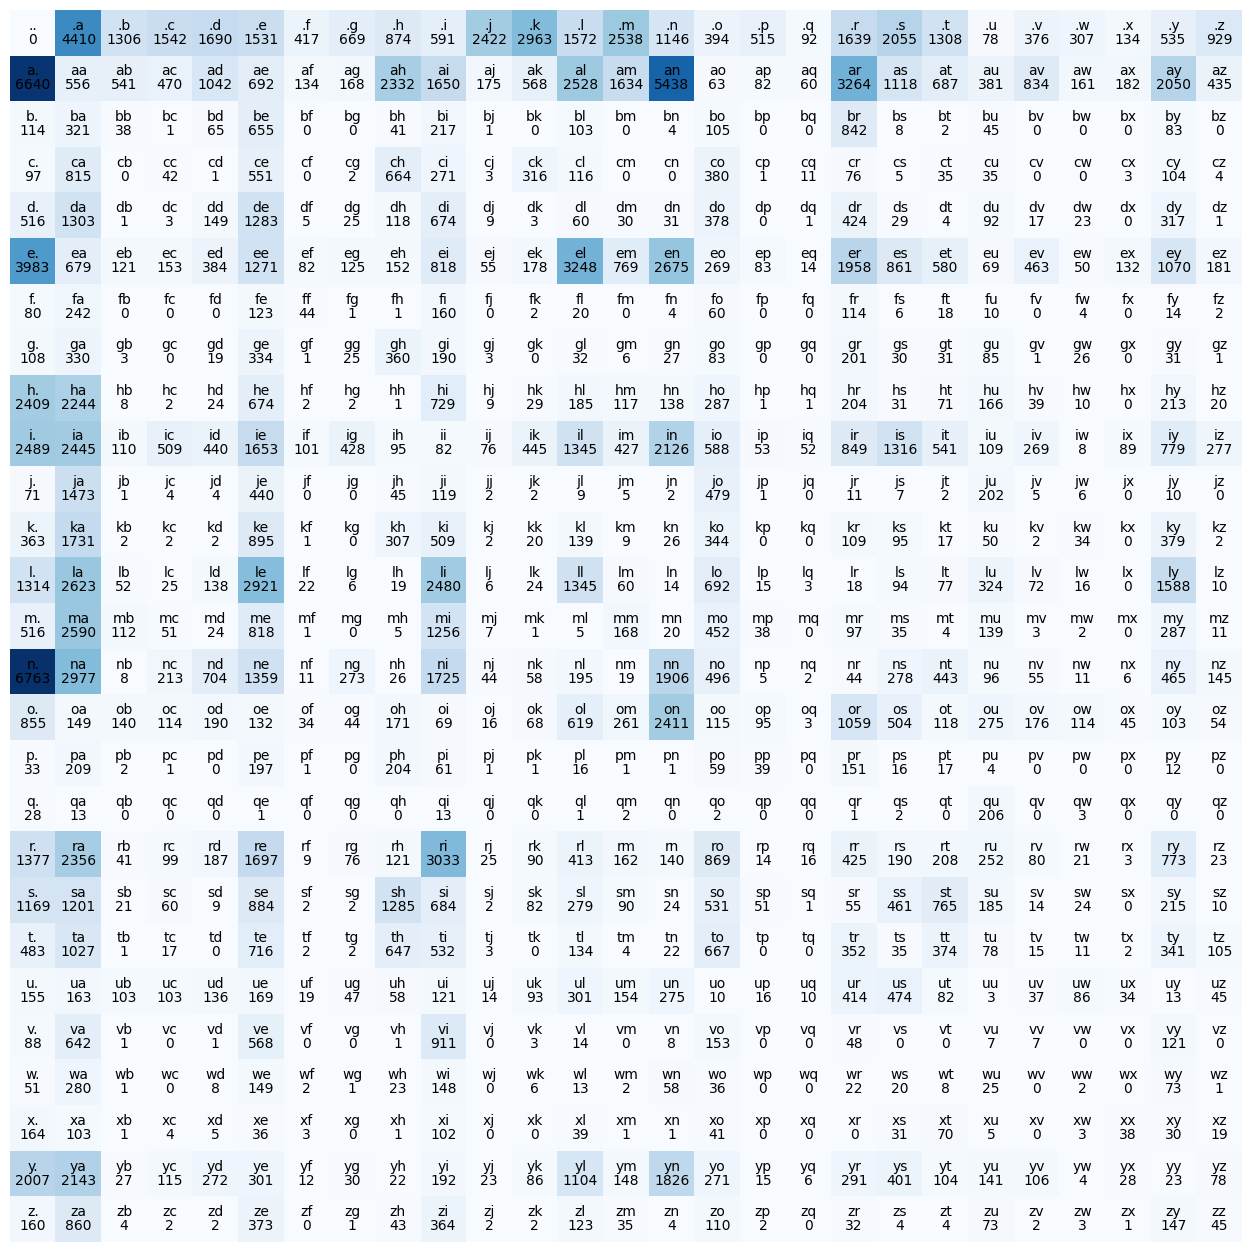

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16,16))
plt.imshow(N, cmap="Blues")

for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha = "center", va="bottom", color = "black")
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color="black")

  plt.axis("off")

Notice the empty row and column and the 4x4 in bottom right! Not very smart!

Instead of 2 tokens, let's use one token to separate words, a dot.

In [105]:
 N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

### Converting to probabilities

#### torch multinomial

In [106]:
g = torch.Generator().manual_seed(2147483647)

In [107]:
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [108]:
itos[torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item()]

'j'

### Generating names

In [109]:
P = N.float()
P.sum(dim=0, keepdim = True).shape

torch.Size([1, 27])

It is confusing to choose the dim when summing up along an axis, but this helps. As you see, when we sum along the 0th dimension (row), we basically sum up all the rows, resulting in just one row and 27 cols.

What we need though, is along column, so it sums up all columns and results in one column

In [110]:
P

tensor([[0.0000e+00, 4.4100e+03, 1.3060e+03, 1.5420e+03, 1.6900e+03, 1.5310e+03,
         4.1700e+02, 6.6900e+02, 8.7400e+02, 5.9100e+02, 2.4220e+03, 2.9630e+03,
         1.5720e+03, 2.5380e+03, 1.1460e+03, 3.9400e+02, 5.1500e+02, 9.2000e+01,
         1.6390e+03, 2.0550e+03, 1.3080e+03, 7.8000e+01, 3.7600e+02, 3.0700e+02,
         1.3400e+02, 5.3500e+02, 9.2900e+02],
        [6.6400e+03, 5.5600e+02, 5.4100e+02, 4.7000e+02, 1.0420e+03, 6.9200e+02,
         1.3400e+02, 1.6800e+02, 2.3320e+03, 1.6500e+03, 1.7500e+02, 5.6800e+02,
         2.5280e+03, 1.6340e+03, 5.4380e+03, 6.3000e+01, 8.2000e+01, 6.0000e+01,
         3.2640e+03, 1.1180e+03, 6.8700e+02, 3.8100e+02, 8.3400e+02, 1.6100e+02,
         1.8200e+02, 2.0500e+03, 4.3500e+02],
        [1.1400e+02, 3.2100e+02, 3.8000e+01, 1.0000e+00, 6.5000e+01, 6.5500e+02,
         0.0000e+00, 0.0000e+00, 4.1000e+01, 2.1700e+02, 1.0000e+00, 0.0000e+00,
         1.0300e+02, 0.0000e+00, 4.0000e+00, 1.0500e+02, 0.0000e+00, 0.0000e+00,
         8.4200e+

In [111]:
P.sum(dim=1,keepdim=True)

tensor([[32033.],
        [33885.],
        [ 2645.],
        [ 3532.],
        [ 5496.],
        [20423.],
        [  905.],
        [ 1927.],
        [ 7616.],
        [17701.],
        [ 2900.],
        [ 5040.],
        [13958.],
        [ 6642.],
        [18327.],
        [ 7934.],
        [ 1026.],
        [  272.],
        [12700.],
        [ 8106.],
        [ 5570.],
        [ 3135.],
        [ 2573.],
        [  929.],
        [  697.],
        [ 9776.],
        [ 2398.]])

In [112]:
# Model smoothing so no zeros in prob matrix, and hence no infinity
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

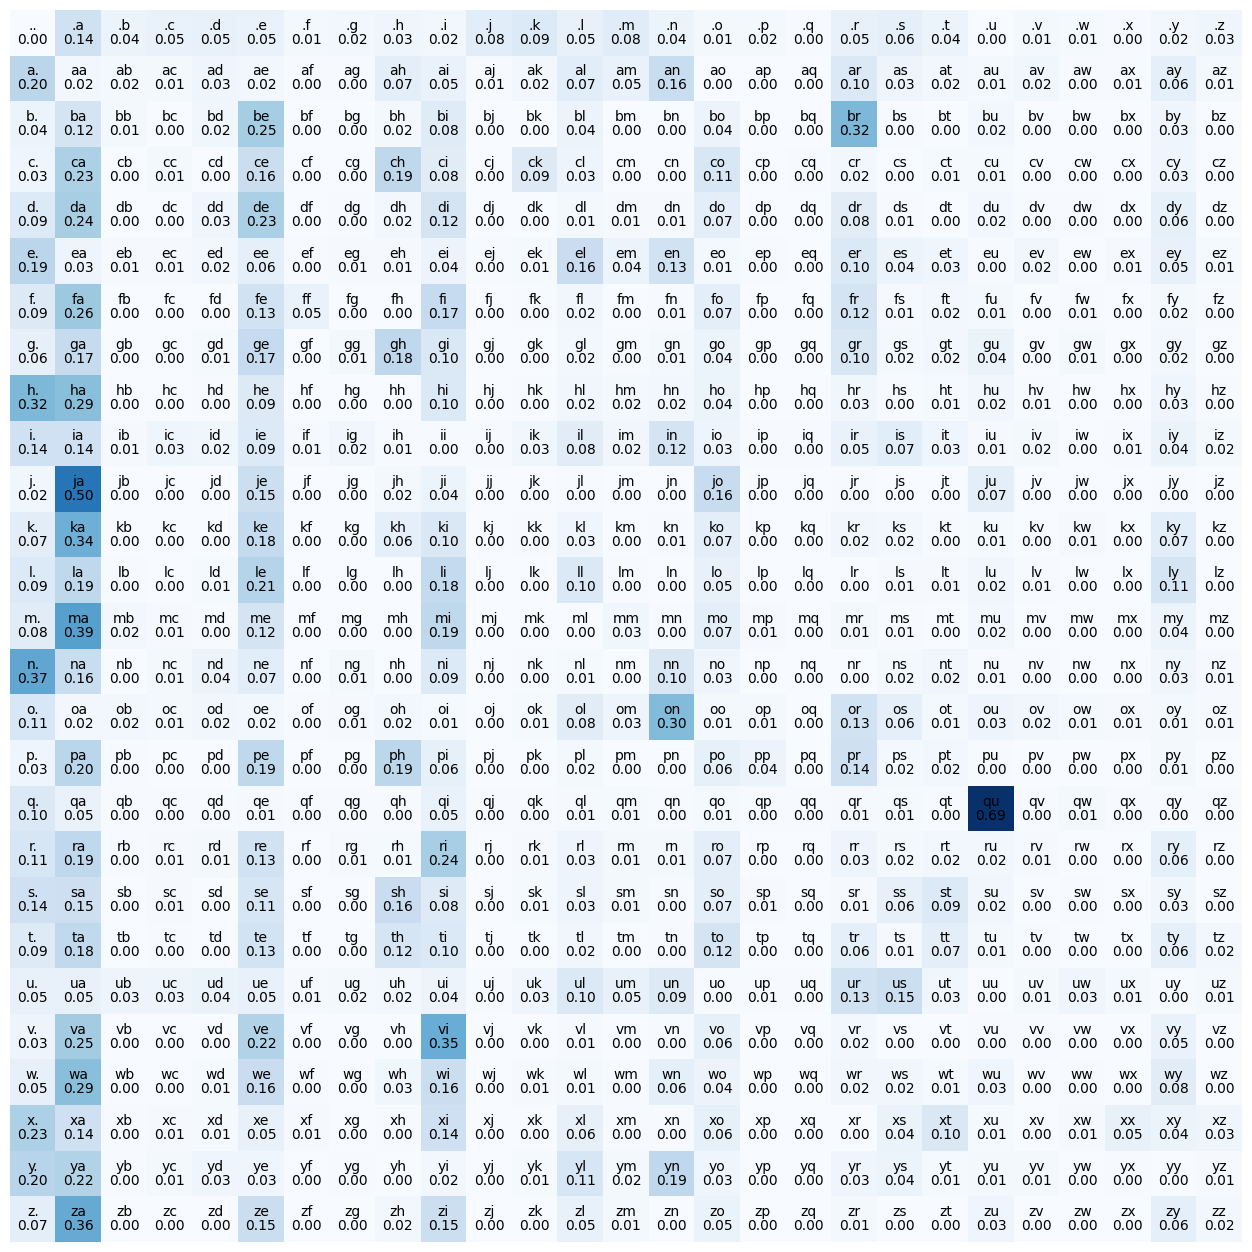

In [113]:
plt.figure(figsize = (16,16))
plt.imshow(P, cmap="Blues")

for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha = "center", va="bottom", color = "black")
    plt.text(j, i, format(P[i, j].item(), ".2f"), ha="center", va="top", color="black")

  plt.axis("off")

In [114]:
P[0].sum()

tensor(1.)

In [115]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while True:
    # p = torch.ones(27) / 27.0
    p = P[ix]
    # p = N[ix].float()
    # p = p/p.sum()
    ix = torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


BOOM, NAMES!!!!!!!

## Measuring model perf

We have probabilities now, that the model calculated after "learning"

In [116]:
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    print(f"{ch1}{ch2}: {prob:.4f}")

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a.: 0.1958
.o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a.: 0.1958
.a: 0.1376
av: 0.0246
va: 0.2473
a.: 0.1958


A perfect model would have probability 1 for all the bigrams above, as it is the training data. So how do you measure the "goodness" of the model?

Likelihood = product of individual probabilities!

In [117]:
likelihood = 1.0
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    likelihood *= prob
    print(f"{ch1}{ch2}: {prob:.4f}")
print(f"{likelihood=:.20f}")

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a.: 0.1958
.o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a.: 0.1958
.a: 0.1376
av: 0.0246
va: 0.2473
a.: 0.1958
likelihood=0.00000000000000001398


Not very readable. Better to use log likelihood.

Log(a * b * c) = log(a) + log(b) + log(c) and Log(1) = 0

(model with probability 1 will yield loss 0)

But also, log results in negative values when 0 < x < 1, so the loss won't make much sense. Loss in terms of ML/AI is a quantity where higher number means model bad and lower number means model good.

So, we flip the minus sign!

In [118]:
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    log_prob = torch.log(prob)
    log_likelihood += log_prob
    n+=1

print(f"Log Likelihood = {log_likelihood}\nNormalised = {log_likelihood/n}")
print(f"Neg Log Likelihood = {-log_likelihood}\nNormalised = {-log_likelihood/n}")

Log Likelihood = -559951.5625
Normalised = -2.4543561935424805
Neg Log Likelihood = 559951.5625
Normalised = 2.4543561935424805


Goal: Maximise **likelihood** of the data w.r.t some parameters (statistical modeling)

Maximise log likelihood

Minimise neg log likelihood


## Neural Network!

### Create training set of all bigrams

In [119]:
# Bigram = (x, y)
xs, ys = [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [120]:
ys

tensor([ 5, 13, 13,  1,  0])

In [121]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes = 27).float()

In [122]:
xenc.shape

torch.Size([5, 27])

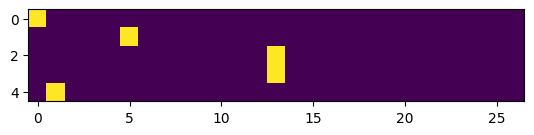

In [123]:
plt.imshow(xenc)

In [124]:
W = torch.randn((27, 27))

In [125]:
xenc[3].dot(W[:,13])

tensor(1.0963)

In [126]:
logits = xenc @ W # log counts
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)


# last 2 lines are basically "softmax"
# normalised exponentiation

In [127]:
prob

tensor([[0.0140, 0.0240, 0.0318, 0.0513, 0.0418, 0.0197, 0.0110, 0.0084, 0.0735,
         0.0055, 0.0829, 0.0451, 0.0088, 0.0648, 0.0794, 0.0095, 0.0186, 0.0332,
         0.0262, 0.0169, 0.0135, 0.1575, 0.0279, 0.0136, 0.1057, 0.0028, 0.0127],
        [0.0175, 0.0130, 0.0495, 0.0054, 0.0821, 0.0186, 0.0051, 0.1160, 0.0135,
         0.0209, 0.0134, 0.0903, 0.0362, 0.0442, 0.0369, 0.0142, 0.0779, 0.0531,
         0.0076, 0.0095, 0.0173, 0.0168, 0.0112, 0.0065, 0.2104, 0.0096, 0.0033],
        [0.0813, 0.0601, 0.0016, 0.0110, 0.0238, 0.0252, 0.0267, 0.0156, 0.0008,
         0.0427, 0.0802, 0.0740, 0.0137, 0.0735, 0.0089, 0.0170, 0.1227, 0.0666,
         0.0501, 0.0201, 0.0197, 0.0272, 0.0068, 0.0053, 0.0588, 0.0594, 0.0076],
        [0.0813, 0.0601, 0.0016, 0.0110, 0.0238, 0.0252, 0.0267, 0.0156, 0.0008,
         0.0427, 0.0802, 0.0740, 0.0137, 0.0735, 0.0089, 0.0170, 0.1227, 0.0666,
         0.0501, 0.0201, 0.0197, 0.0272, 0.0068, 0.0053, 0.0588, 0.0594, 0.0076],
        [0.0038, 0.0148,

In [128]:
prob[0].sum()
# because of normalisation

tensor(1.0000)

In [129]:
max(prob[0])

tensor(0.1575)

- We are now getting the probability of the next character given the previous character.
- Question now is: Can we find an optimal W that gets us the best probability distribution? (I think optimal distribution is where training loss is zero and it matches that completely)

- It's not possible for a zero training loss, however, because there will definitely be contradicting examples in the training set. There will be names where e follows h and names where e follows f. Model can't satisfy both cases during inference and will balance according to its frequency i guess.

In [130]:
#neg log likelihood
nlls = torch.zeros(5)

for i in range(5):
    #i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    print("------------")
    print(f"bigram example {i + 1}: {itos[x]}|{itos[y]} (indexes {x} {y})")
    print("input to the neural net ", x)
    print("actual output ", y)
    p = prob[i, y]
    print("prob assigned to the actual next char ", p.item())
    predChar = itos[torch.argmax(prob[i]).item()]
    print("network thinks the next char should be ", predChar)
    logp = torch.log(p)
    nll = -logp
    print("neg log likelihood: ", nll)
    nlls[i] = nll

print("average neg log likelihood: ", nlls.mean().item())

------------
bigram example 1: .|e (indexes 0 5)
input to the neural net  0
actual output  5
prob assigned to the actual next char  0.01965232379734516
network thinks the next char should be  u
neg log likelihood:  tensor(3.9296)
------------
bigram example 2: e|m (indexes 5 13)
input to the neural net  5
actual output  13
prob assigned to the actual next char  0.044192150235176086
network thinks the next char should be  x
neg log likelihood:  tensor(3.1192)
------------
bigram example 3: m|m (indexes 13 13)
input to the neural net  13
actual output  13
prob assigned to the actual next char  0.07345444709062576
network thinks the next char should be  p
neg log likelihood:  tensor(2.6111)
------------
bigram example 4: m|a (indexes 13 1)
input to the neural net  13
actual output  1
prob assigned to the actual next char  0.06005847081542015
network thinks the next char should be  p
neg log likelihood:  tensor(2.8124)
------------
bigram example 5: a|. (indexes 1 0)
input to the neural ne

### Optimizing our NEURAL NET WOOOOOOO

In [131]:
xs

tensor([ 0,  5, 13, 13,  1])

In [132]:
ys

tensor([ 5, 13, 13,  1,  0])

In [133]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad = True)

In [134]:
#fwd pass
xenc = F.one_hot(xs, num_classes = 27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims = True)
loss = -probs[torch.arange(5), ys].log().mean()

In [135]:
probs.shape

torch.Size([5, 27])

In [136]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [137]:
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]

(tensor(0.0123, grad_fn=<SelectBackward0>),
 tensor(0.0181, grad_fn=<SelectBackward0>),
 tensor(0.0267, grad_fn=<SelectBackward0>),
 tensor(0.0737, grad_fn=<SelectBackward0>),
 tensor(0.0150, grad_fn=<SelectBackward0>))

In [138]:
print(loss.item())

3.7693049907684326


In [139]:
# backward pass
W.grad = None

loss.backward()

In [140]:
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [141]:
# Updating weights!
W.data += -0.1 * W.grad

### Assembling our neural net

#### Creating Dataset

In [142]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print("num of examples: ", xs.nelement())

# initialise weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad = True)

num of examples:  228146


#### Forward and backward passes

In [143]:
# Gradient descent
for k in range(100):

    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True)
    loss = -probs[torch.arange(xs.nelement()), ys].log().mean()
    print(f"{k + 1} | Loss : {loss.item()}")

    # backward pass
    W.grad = None
    loss.backward()

    # update params
    W.data += -50 * W.grad

1 | Loss : 3.758953809738159
2 | Loss : 3.371100664138794
3 | Loss : 3.1540427207946777
4 | Loss : 3.020373821258545
5 | Loss : 2.927711009979248
6 | Loss : 2.8604023456573486
7 | Loss : 2.8097288608551025
8 | Loss : 2.7701022624969482
9 | Loss : 2.7380728721618652
10 | Loss : 2.711496591567993
11 | Loss : 2.6890032291412354
12 | Loss : 2.6696884632110596
13 | Loss : 2.65293025970459
14 | Loss : 2.638277292251587
15 | Loss : 2.6253879070281982
16 | Loss : 2.613990545272827
17 | Loss : 2.60386323928833
18 | Loss : 2.5948219299316406
19 | Loss : 2.586712121963501
20 | Loss : 2.5794036388397217
21 | Loss : 2.572788953781128
22 | Loss : 2.5667762756347656
23 | Loss : 2.5612878799438477
24 | Loss : 2.5562589168548584
25 | Loss : 2.551633596420288
26 | Loss : 2.547365665435791
27 | Loss : 2.543415069580078
28 | Loss : 2.5397486686706543
29 | Loss : 2.536336660385132
30 | Loss : 2.5331544876098633
31 | Loss : 2.5301806926727295
32 | Loss : 2.5273969173431396
33 | Loss : 2.5247862339019775
34 

#### Regularisation: Why and How it fits in

- As we added fake counts to our count vector earlier, so that we don't face 0 counts and sort of smooth out the vector.
- If we increase the amount of fake counts to a million, the range of the relative counts will be much smaller, and therefore the distribution will be much more equal.

SIMILARLY
- For our neural net, suppose our weights are initialised with zero.
- the x @ w will give us a vector of zeros
- exponentiating that gets us a vector of ones, indicating that all characters have equal probability!
- This is the same as appending a huge number to the count vectors!!!



- Instead of setting the weights to zero or a low number, we can add it to the loss and let the network optimise it.
- A common way of adding this "smoothing" or "regularisation" is by adding the mean of squares of the weight matrix. If the weights are close to zero, the mean will be close to zero and this term won't contribute to the loss much.

- It is important to remember that this is one of many ways to do it. You can also just take the mean of the weights but it won't properly deal with negative values. Whatever works!

#### Sampling from our model

In [145]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while True:
    # p = torch.ones(27) / 27.0
    # p = P[ix]
    # p = N[ix].float()
    # p = p/p.sum()
    xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True)

    ix = torch.multinomial(probs, num_samples = 1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break

  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


WHAT ITS THE EXACT SAME Gjklsdfds